In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import scipy as sc
from scipy import linalg, stats, special
import copy
import pickle

In [2]:
#Setting Up GPU Growth. Helps getting rid of out of memory errors
physical_devices=tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(physical_devices))
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs available:  1


In [3]:
embed=load_model('embed.h5')
with open('data_sorted.npy', 'rb') as f:
    data = np.load(f)

In [4]:
def prediction(dat):
    tmp=[]
    for i in range(len(dat)):
        temp=dat[i]
        temp=np.reshape(temp,(-1,28,28,1))
        tmp.append(embed.predict(x=temp))
    return(np.array(tmp))

In [5]:
class GMM:
    '''
    This class is the implementation of the Gaussian Mixture Model
    '''
    def __init__ (self,cluster,max_iter=100):
        '''This Function initialises the model by setting the parameters
               :param n_components: int
                    The number of clusters in which the algorithm must split
                    the data set
               :param max_iter: int, default = 100
                    The number of iteration that the algorithm will go throw to find the clusters
        '''
        self.cluster=cluster
        self.max_iter=max_iter
        self.w = [1/self.cluster for comp in range(self.cluster)]
    
    def initialise(self, X):
        '''We are using Kmeans to initialise the data into n clusters. we will be extracting the means 
           from the Kmeans algo itself and generate the covariance matrix of each cluster based on the prediction of the 
           Kmeans algorithm
        '''
    
        kmeans=KMeans(n_clusters=self.cluster, random_state=98).fit(X)
        l=kmeans.labels_
        d=[]
        for i in range(self.cluster):
            tmp=[]
            for j in range(l.shape[0]):
                if l[j]==i:
                    tmp.append(X[j])
            d.append(np.asarray(tmp))
        # Generate Means of the Clusters which will be used as Initialised
        self.mean=kmeans.cluster_centers_
        #Generate Covariance Matrix of the clusters
        self.cov=[]
        for i in range(self.cluster):
            tmp=d[i]
            tmp2=np.cov(tmp, rowvar=False)
            self.cov.append(np.asarray(tmp2))
        self.cov=np.asarray(self.cov)
        
    def fit(self,X):
        #Initialise the Means and Covariance using the Kmeans Algorithm
        self.initialise(X)
        for iteration in range(self.max_iter):
            #print("Round ", iteration)
            if iteration%20==0:
                print("Round ", iteration)
            
            ''' --------------------------   E - STEP   -------------------------- '''
            # Initiating the r matrix, evrey row contains the probabilities
            # for every cluster for this row
            self.r = np.zeros((len(X), self.cluster))
            # Calculating the r matrix
            for i in range(len(X)):
                self.r_data = np.zeros(self.cluster)
                for j in range(self.cluster):
                    self.r_data[j]=self.w[j] * sc.stats.multivariate_normal.pdf(X[i], self.mean[j], self.cov[j])
                for j in range(self.cluster):
                    self.r[i][j] =   self.r_data[j] / np.sum(self.r_data)
            # Calculating the N
            self.N = np.sum(self.r, axis=0)
            
            '''--------------------------   M - STEP   -------------------------- '''
            # Initializing the mean vector as a zero vector
            self.mean_vector=np.zeros((self.cluster,X.shape[1]))
            self.covariance=np.zeros((self.cluster,X.shape[1],X.shape[1]))
            
            # Updating the mean vector
            for j in range(self.cluster):
                tmp=0
                for i in range(len(X)):
                    tmp+=(self.r[i][j]*X[i])
                self.mean_vector[j]=(1/self.N[j])*(tmp)
            
            #Updating the Covariance
            for j in range(self.cluster):
                tmp=0
                for i in range(len(X)):
                    t=X[i]-self.mean_vector[j]
                    t1=np.outer(t,t)
                    tmp+=(self.r[i][j]*t1)
                self.covariance[j]=((1/self.N[j])*(tmp))
                
            
            # Updating the weight list
            self.w = [self.N[k]/len(X) for k in range(self.cluster)]
            self.mean=copy.deepcopy(self.mean_vector)
            self.cov=copy.deepcopy(self.covariance)
            logL=0
            if iteration == self.max_iter-1:
                #Calculate the Log likelihood and return the value
                logLall = np.zeros((len(X)))
                for i in range(len(X)):
                    LH = np.zeros(self.cluster)
                    for j in range(self.cluster):
                        LH[j] = self.w[j] * sc.stats.multivariate_normal.pdf(X[i], self.mean[j], self.cov[j])
                    logLall[i] = np.log(np.sum(LH))  
                logL = np.sum(logLall)
        return logL
            
            
    def predict(self,X):
        '''
            The predicting function
                :param X: 2-d array numpy array
                    The data on which we must predict the clusters
        '''
        probas = []
        for i in range(len(X)):
            tmp=[]
            for j in range(self.cluster):
                tmp.append(sc.stats.multivariate_normal.pdf(X[i], self.mean[j], self.cov[j]))
            probas.append(np.asarray(tmp))
        probas=np.asarray(probas)
        cluster = []
        for proba in probas:
            cluster.append(np.argmax(proba))
        return cluster

In [6]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                             angle, **kwargs))

In [7]:
#Initialise all the information
def plot_gmm(x,cluster,gmm,labels=True,ax=None):
    
    
    gmm.fit(x)
    label=gmm.predict(x)
    ax = ax or plt.gca()
    if labels:
        ax.scatter(x[:, 0], x[:, 1], c=label, s=7, cmap='viridis', zorder=2)
    else:
        ax.scatter(x[:, 0], x[:, 1], s=7, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / np.max(gmm.w)
    for pos, covar, w in zip(gmm.mean, gmm.cov, gmm.w):
        draw_ellipse(pos, covar, alpha=w * w_factor)

438/438 [==============================] - 1s 2ms/step
Round  0
Round  20
Round  40
Round  60
Round  80


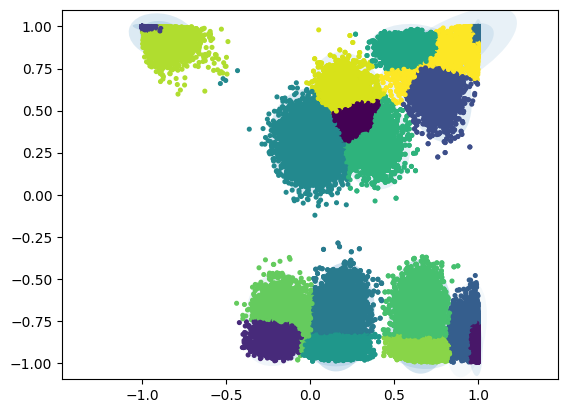

In [8]:
label_sort=prediction(data)
x2=label_sort.reshape((98000,2))
cluster=18
gmm=GMM(cluster)
plot_gmm(x2,cluster,gmm)
plt.show()